<div class="alert alert-success">
    <h1 align="center">One Shot Learning with Siamese Networks</h1>
   
</div>

<h1 align="center">Contrastive Loss</h1>

## Topics

- Face Recognition
- Siamese Network
- Triplet loss and Contrastive loss
- Defining and implementing our Dataset class.

### Libraries

In [ ]:
%matplotlib inline

import glob
import shutil

from tqdm import tqdm
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

### Helper methods

In [ ]:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

def create_validation_data(trn_dir, val_dir, split=0.1, ext='png'):
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
        
    train_ds = glob.glob(trn_dir + f'/*/*.{ext}')
    print(len(train_ds))
    
    valid_sz = int(split * len(train_ds)) if split < 1.0 else split 
    
    valid_ds = random.sample(train_ds, valid_sz)
    print(len(valid_ds))
    
    for fname in tqdm(valid_ds):
        basename = os.path.basename(fname)
        label = fname.split('\\')[-2]
        src_folder = os.path.join(trn_dir, label)
        tgt_folder = os.path.join(val_dir, label)
        if not os.path.exists(tgt_folder):
            os.mkdir(tgt_folder)
        shutil.move(os.path.join(src_folder, basename), os.path.join(tgt_folder, basename))


### Data

Here, we will use [Cambridge AT&T Face Dataset](https://www.kaggle.com/kasikrit/att-database-of-faces).
- It contains images from 40 different persons.
- For each person, there are 10 different images.

In [ ]:
DATA_DIR = './datasets/att_faces/'
train_dir = f'{DATA_DIR}train/'
valid_dir = f'{DATA_DIR}valid/'
train_batch_size = 64
train_number_epochs = 50
size = 100
   
embed_size = 128
cnn_name = 'resnet101'

In [ ]:
# make validation dataset
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='jpg')

### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:

1. Create a subclass of `torch.utils.data.Dataset`
2. Override the following three methods:
 - The constructor or `__init__()`: this method is required to initialize the dataset object.
 - The `__getitem__()` method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.
 - The `__len__()` method: this method returns number of data in the dataset.

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imgs,transform=None,should_invert=True):
        self.imgs = imgs    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imgs.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imgs.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imgs.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0]).convert("L")
        img1 = Image.open(img1_tuple[0]).convert("L")
        
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imgs.imgs)

#### Training data

In [ ]:
zoom = int((1.0 + random.random() / 10.0) * size)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = SiameseNetworkDataset(imgs=face_dataset, transform=tfms, should_invert=False)
train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, num_workers=0)

#### Validation data

In [ ]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = SiameseNetworkDataset(imgs = valid_face_dataset, transform=tfms,should_invert=False)
valid_dl = DataLoader(valid_ds,shuffle =True,num_workers = 0,batch_size = 1)

### Visualize dataset
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

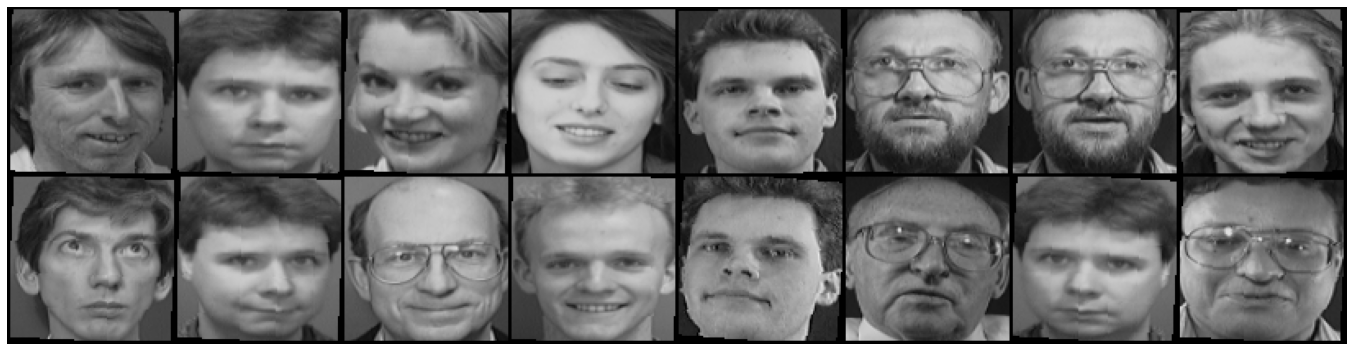

In [ ]:
vis_dataloader = DataLoader(train_ds,shuffle=True,num_workers=0, batch_size=8)

dataiter = iter(vis_dataloader)
example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concatenated,nrow=8))

## Model: Siamese Netwok

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Loss: Contrastive Loss

Given a pair of images and the corresponding label (0 or 1), the contrastive loss is defined as:
- if $y = 0$:
$$\lVert f(a) - f(b) \rVert^2$$
- if $y = 1$:
$$\max (\alpha - \lVert f(a) - f(b) \rVert, 0)^2$$

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0002 )

for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_dl,0):
        img0, img1 , label = data
        img0, img1 , label = img0, img1 , label
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())


Epoch number 0
 Current loss 1.6980599164962769

Epoch number 1
 Current loss 0.948270320892334

Epoch number 2
 Current loss 0.7293645739555359

Epoch number 3
 Current loss 0.8376995325088501

Epoch number 4
 Current loss 0.7441346645355225

Epoch number 5
 Current loss 0.6118839383125305

Epoch number 6
 Current loss 0.5271700620651245

Epoch number 7
 Current loss 0.4778114855289459

Epoch number 8
 Current loss 0.4416268467903137

Epoch number 9
 Current loss 0.3507753610610962

Epoch number 10
 Current loss 0.3060038089752197

Epoch number 11
 Current loss 0.25612035393714905

Epoch number 12
 Current loss 0.37493637204170227

Epoch number 13
 Current loss 0.23537790775299072

Epoch number 14
 Current loss 0.34497585892677307

Epoch number 15
 Current loss 0.27162736654281616

Epoch number 16
 Current loss 0.18103596568107605

Epoch number 17
 Current loss 0.21897399425506592

Epoch number 18
 Current loss 0.28225019574165344

Epoch number 19
 Current loss 0.1293923556804657

Epo

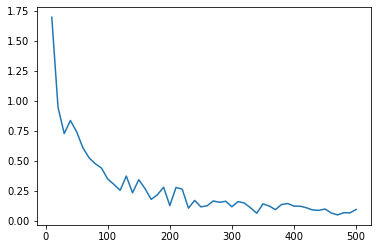

In [ ]:
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

1 1


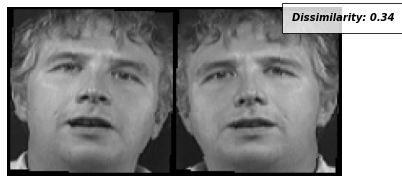

1 1


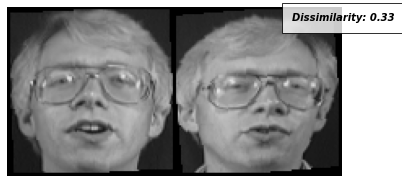

1 1


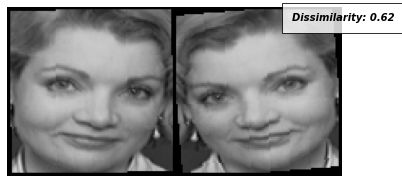

1 1


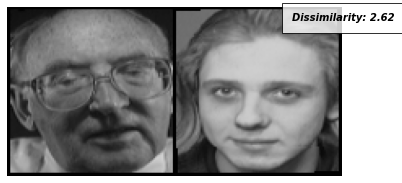

1 1


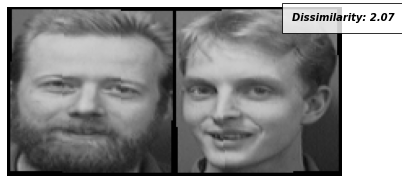

1 1


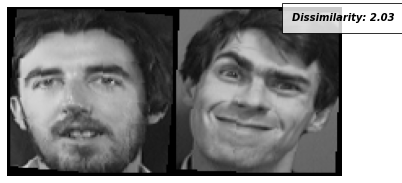

1 1


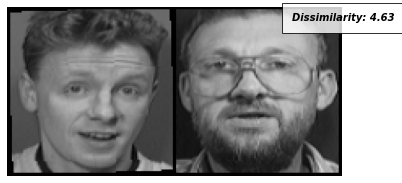

1 1


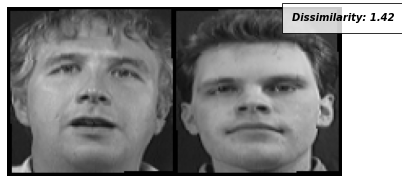

1 1


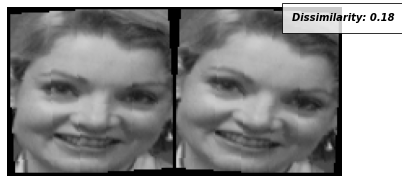

1 1


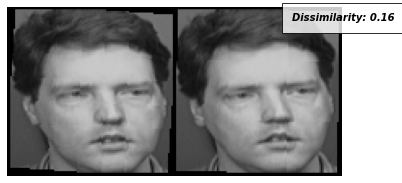

In [ ]:
dataiter = iter(valid_dl)

for i in range(10):
    x0,x1,label2 = next(dataiter)
    print(len(x1),len(x1))
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

<h1 align="center">Triplet Loss</h1>

In [ ]:
size = 224
batch_size = 16
embed_size = 128
num_epochs = 50

cnn_name = 'resnet34'

In [ ]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [ ]:
zoom = int((1.0 + random.random() / 10.0) * size)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])


face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

#### Validation data

In [ ]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True, num_workers=0)

### Visualize dataset

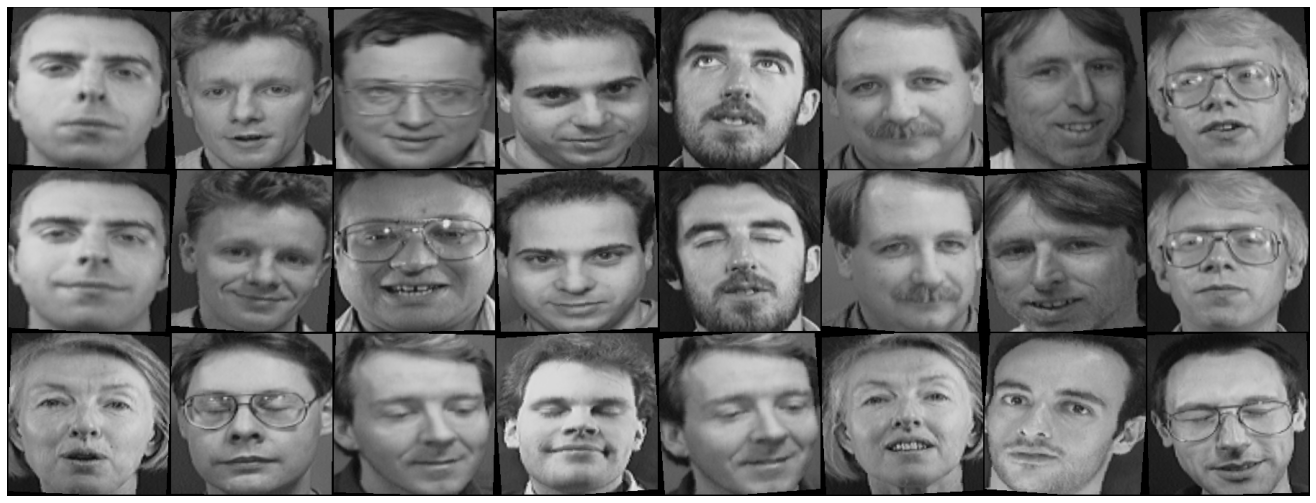

In [ ]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

## Model: Triplet Netwok

In [ ]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## Loss: Triplet Loss
Given a triplet $(a, p, n)$, the loss is defined as following:

$$L(a, p, n) = \max (\lVert f(a) - f(p) \rVert^2 - \lVert f(a) - f(n) \rVert^2 + \alpha, 0)$$

In wich:
- $a$ is the anchor image
- $p$ is the positive example, and
- $n$ is the negative example.

Also, $f(.)$ is the vector of features extracted from a CNN (i.e., embedding vector).

In [ ]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

## Train

In [ ]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = Variable(anc), Variable(pos), Variable(neg)
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(valid_dl):
        anc = Variable(anc, volatile=True)
        pos = Variable(pos, volatile=True)
        neg = Variable(neg, volatile=True)
        
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train (model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=100):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer)
        valid_loss = validate_step(model, valid_dl, criterion)
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    return model, best_weights, loss_history

In [ ]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# model
cnn = get_model(cnn_name)
model = TripletNetwork(cnn, embed_size)

# loss and optimizer
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

## Training

In [ ]:
model, best_weights, loss_hist = train(model, train_dl, valid_dl, 
                                       criterion, optimizer, 
                                       num_epochs=num_epochs)

Epoch 0
--------
 Training Step [20/20]: loss 20.78302  


<ipython-input-16-2df00ca77dab>:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  anc = Variable(anc, volatile=True)
<ipython-input-16-2df00ca77dab>:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  pos = Variable(pos, volatile=True)
<ipython-input-16-2df00ca77dab>:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  neg = Variable(neg, volatile=True)


 Validation Step [ 5/ 5]: loss 2.04002  

Epoch 1
--------
 Training Step [20/20]: loss 5.68150  
 Validation Step [ 5/ 5]: loss 21.11114  

Epoch 2
--------
 Training Step [20/20]: loss 6.78629   
 Validation Step [ 5/ 5]: loss 9.51691  

Epoch 3
--------
 Training Step [20/20]: loss 3.21423   
 Validation Step [ 5/ 5]: loss 3.44996  

Epoch 4
--------
 Training Step [20/20]: loss 2.21679  
 Validation Step [ 5/ 5]: loss 2.47727  

Epoch 5
--------
 Training Step [20/20]: loss 2.02537  
 Validation Step [ 5/ 5]: loss 1.57709  

Epoch 6
--------
 Training Step [20/20]: loss 1.60633  
 Validation Step [ 5/ 5]: loss 0.27439  

Epoch 7
--------
 Training Step [20/20]: loss 0.94437  
 Validation Step [ 5/ 5]: loss 2.10478  

Epoch 8
--------
 Training Step [20/20]: loss 1.47405  
 Validation Step [ 5/ 5]: loss 0.86347  

Epoch 9
--------
 Training Step [20/20]: loss 0.77210  
 Validation Step [ 5/ 5]: loss 0.35891  

Epoch 10
--------
 Training Step [20/20]: loss 0.47973  
 Validation Step

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [ ]:
torch.save(model.state_dict(), f'{cnn_name}-facereco-triplet-{num_epochs}.pth')

## Testing

In [ ]:
model.load_state_dict(torch.load('weights/resnet101-facereco-triplet-50.pth'))

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

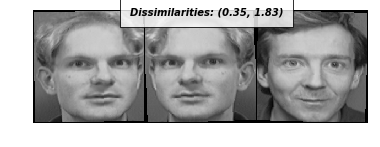

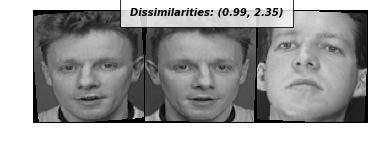

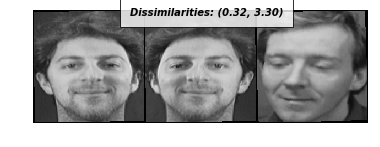

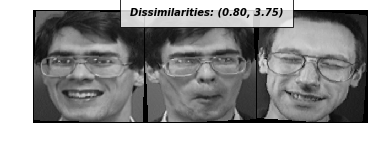

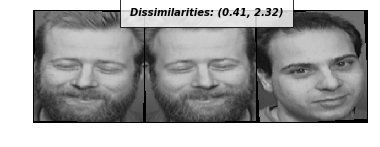

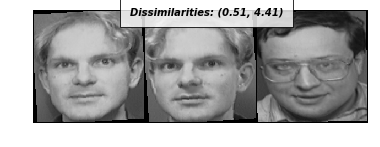

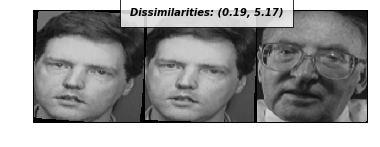

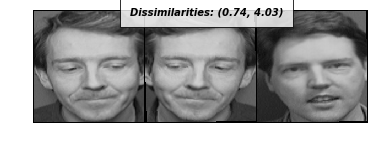

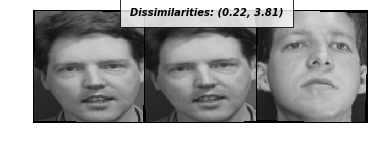

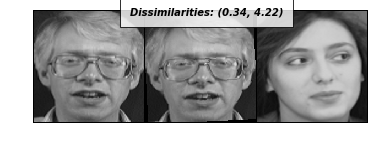

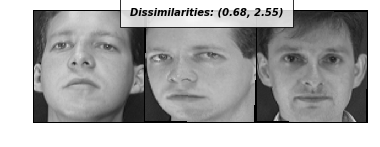

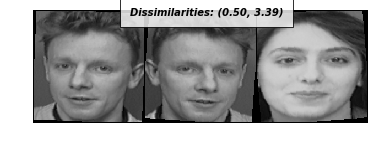

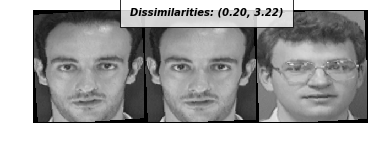

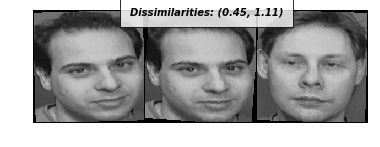

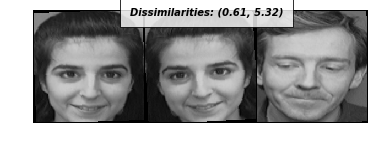

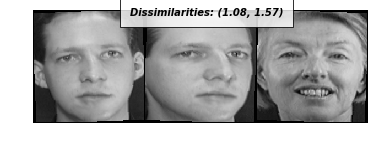

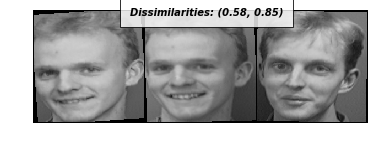

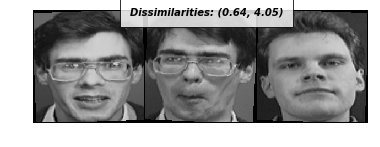

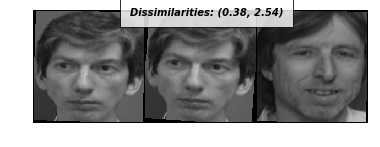

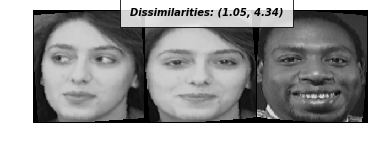

In [ ]:
model.eval()

dataiter = iter(valid_dl)
for i in range(20):
    x0, x1, x2 = next(dataiter)
    concat = torch.cat((x0, x1, x2), 0)
    f0, f1, f2 = model(Variable(x0), Variable(x1), Variable(x2)
    pos_distance = F.pairwise_distance(f0, f1)
    neg_distance = F.pairwise_distance(f0, f2)
    imshow(torchvision.utils.make_grid(concat), 'Dissimilarities: ({:.2f}, {:.2f})'.format(pos_distance.cpu().data.numpy()[0][0], 
                                                                                           neg_distance.cpu().data.numpy()[0][0]))